First we need to import the necessary modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from beeswarm import beeswarm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ttest_ind
from matplotlib.patches import Ellipse,Patch,Arrow
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
from IPython.display import HTML, display
import tabulate
from decimal import Decimal
import warnings
warnings.filterwarnings('ignore') #in order to suppress warnings output of t-test if one sample is 0
pd.set_option('display.max_rows', 1000)

The we read sample files and extract separate data containers for the 4 tissues in question. The data have been normalized. (How?)

In [2]:
sampleinfo=pd.read_csv('sample_info_consensus.csv',sep=',')
sampleinfo=sampleinfo.query('paper == "fromm" or paper == "schee" or paper == "selitsky" or paper == "neerincx"')
countmat=pd.read_csv('consensus.rpm_uniq_seqs_correct_names.csv',sep=',')
countmat.rename(columns = {'Unnamed: 0':'mirna'}, inplace = True)
liver_normal=countmat[[row[0] for row in sampleinfo.values if row[3]=='liver' and row[2]=='normal']]
liver_meta=countmat[[row[0] for row in sampleinfo.values if row[3]=='liver' and row[2]=='metastasis']]
crc_normal=countmat[[row[0] for row in sampleinfo.values if row[3]=='colorect' and row[2]=='normal' and row[4]!='schee']]
crc_tumor=countmat[[row[0] for row in sampleinfo.values if row[3]=='colorect' and row[2]=='tumor']]
liver_normal.index=liver_meta.index=crc_normal.index=crc_tumor.index=list(countmat['mirna'])

For each miRNA, certain values are calculated such as t-test relevance values between different tissue types, fold changes between average values and count of samples. This is later used to filter the data. Also, miRNAs that are known to be tissue-related are excluded.

In [3]:
mirnanamelist=[]
mirnadatalist=[]
tissuemirna=["Hsa-Mir-122_5p ","Hsa-Mir-126_5p ","Hsa-Mir-126_3p ","Hsa-Mir-144_5p ","Hsa-Mir-144_3p ","Hsa-Mir-486_5p ",
             "Hsa-Mir-143_3p ","Hsa-Mir-145_5p ","Hsa-Mir-150_5p ","Hsa-Mir-142-P1_5p ","Hsa-Mir-223_3p "]
for i in range(len(countmat.values)):
    s1,p1=ttest_ind(crc_normal.values[i],crc_tumor.values[i])
    s2,p2=ttest_ind(crc_tumor.values[i],liver_meta.values[i])
    s3,p3=ttest_ind(crc_normal.values[i],liver_normal.values[i])
    s4,p4=ttest_ind(liver_meta.values[i],liver_normal.values[i])
    fc_cm_cb=np.mean(crc_tumor.values[i])/np.mean(crc_normal.values[i])
    if fc_cm_cb<1:fc_cm_cb=-1/(fc_cm_cb+0.00001)
    fc_lm_cm=np.mean(liver_meta.values[i])/np.mean(crc_tumor.values[i])
    if fc_lm_cm<1:fc_lm_cm=-1/(fc_lm_cm+0.00001)
    fc_lb_cb=np.mean(liver_normal.values[i])/np.mean(crc_normal.values[i])
    if fc_lb_cb<1:fc_lb_cb=-1/(fc_lb_cb+0.00001)
    fc_lb_lm=np.mean(liver_normal.values[i])/np.mean(liver_meta.values[i])
    if fc_lb_lm<1:fc_lb_lm=-1/(fc_lb_lm+0.00001)
    n_cb=len(crc_normal.values[i])
    n_cm=len(crc_tumor.values[i])
    n_lb=len(liver_normal.values[i])
    n_lm=len(liver_meta.values[i])
    totcounts=np.mean(liver_normal.values[i])+np.mean(liver_meta.values[i])+np.mean(crc_normal.values[i])+np.mean(crc_tumor.values[i])
    tm=False
    if countmat['mirna'][i] in tissuemirna:tm=True
    mirnadatalist.append([p1,p2,p3,p4,fc_cm_cb,fc_lm_cm,fc_lb_cb,fc_lb_lm,n_cb,n_cm,n_lb,n_lm,totcounts,tm])
    mirnanamelist.append(countmat['mirna'][i])
mirnalist=pd.DataFrame(data=mirnadatalist,index=mirnanamelist,columns=[ 
                                               'p_cm_cb',
                                               'p_cm_lm',
                                               'p_cb_lb',
                                               'p_lm_lb',
                                               'fc_cm_cb',
                                               'fc_lm_cm',
                                               'fc_lb_cb',
                                               'fc_lb_lm',
                                               'N_cb',
                                               'N_cm',
                                               'N_lb',
                                               'N_lm',
                                               'total_counts',
                                               'tissue_mirna'])

This is what it looks like for one example miRNA.

In [4]:
mirnalist.T['Hsa-Mir-122_5p ']

p_cm_cb            0.227864
p_cm_lm         4.72873e-07
p_cb_lb         1.28378e-15
p_lm_lb         7.69653e-13
fc_cm_cb           -2.29099
fc_lm_cm            243.423
fc_lb_cb             4146.9
fc_lb_lm            39.0297
N_cb                     24
N_cm                    101
N_lb                     24
N_lm                     19
total_counts         140249
tissue_mirna           True
Name: Hsa-Mir-122_5p , dtype: object

Next we define the visualization function called "combplot". The individual experimental miRNA counts are drawn as vertical (liver) and horizontal (colon) lines. The area where they overlap is indicated by an ellipse with the means as center and the standard deviation as half axes. This is done both for benign and malign tissues. 

The straight green line indicates the equal count where colon and liver counts are the same (FC=1). An arrow indicates the trend from benign to malign. If the ellipse is top left it means the expression for this miRNA is higher in the colon tissue than in the liver tissue while it is lower if the ellipse is in the bottom right.

Additionally, a classical box plot of the four tissues is shown and overlaid with a beeswarm plot that shows individual measurements.

In [5]:
def combplot(mirna):
    #prepare figure
    fig = plt.figure(figsize=(13,7))
    fig.suptitle(mirna,fontsize=20)
    #prepare ellipses subplot
    ax = fig.add_axes([0.1,0.1,0.44,0.44*13/7])
    plt.xlabel('Individual counts (liver)')
    plt.ylabel('Individual counts (colon)')
    plotlimitmax=max(liver_normal.T[mirna].max(),crc_normal.T[mirna].max(),liver_meta.T[mirna].max(),crc_tumor.T[mirna].max())
    plotlimitmin=min(liver_normal.T[mirna].min(),crc_normal.T[mirna].min(),liver_meta.T[mirna].min(),crc_tumor.T[mirna].min())
    ax.set_xlim(plotlimitmin, plotlimitmax)
    ax.set_ylim(plotlimitmin, plotlimitmax)
    #ax.set_aspect('equal')
    #prepare ellipses
    xn=liver_normal.T[mirna].mean()
    yn=crc_normal.T[mirna].mean()
    xerrn=2*liver_normal.T[mirna].std()
    yerrn=2*crc_normal.T[mirna].std()
    xc=liver_meta.T[mirna].mean()
    yc=crc_tumor.T[mirna].mean()
    xerrc=2*liver_meta.T[mirna].std()
    yerrc=2*crc_tumor.T[mirna].std()
    ne=Ellipse(xy=(xn,yn), width=xerrn, height=yerrn,color='blue',lw=2,fill=False,alpha=1,label='Benign (Median+St.d.)')
    ce=Ellipse(xy=(xc,yc), width=xerrc, height=yerrc,color='red',lw=2,fill=False,alpha=1,label='Malign (Media+St.d.)')
    ax.add_artist(ne)
    ax.add_artist(ce)
    ne.set_zorder(10000)
    ce.set_zorder(10000)
    #draw arrow between ellipses centers
    ar=Arrow(xn,yn,xc-xn,yc-yn,width=plotlimitmax/40,zorder=10001,color='purple')
    ax.add_artist(ar)
    #draw green line of constant fold change
    gfc1,=ax.plot([plotlimitmin,plotlimitmax],[plotlimitmin,1*plotlimitmax],'g',label="FC=1")
    gfc2,=ax.plot([plotlimitmin,plotlimitmax],[plotlimitmin,2*plotlimitmax],'g--',label="FC=2")
    gfc05,=ax.plot([plotlimitmin,plotlimitmax],[plotlimitmin,0.5*plotlimitmax],'g-.',label="FC=-2")
    #draw vertical and horizontal lines for each individual measurement
    lw,al=10,0.07
    nleg=Patch(color='black',alpha=al*5,label='Benign (ind. meas.)')
    cleg=Patch(color='yellow',alpha=al*5,label='Malign (ind. meas.)')
    ax.legend(handles=[ne,ce,nleg,cleg,gfc1,gfc2,gfc05],fontsize='small')
    for xln in liver_normal.T[mirna].values:
        ax.plot([xln,xln],[min(crc_normal.T[mirna].values),max(crc_normal.T[mirna].values)],'k-',linewidth=lw,alpha=al)
    for ycn in crc_normal.T[mirna].values:
        ax.plot([min(liver_normal.T[mirna].values),max(liver_normal.T[mirna].values)],[ycn,ycn],'k-',linewidth=lw,alpha=al)
    for xlc in liver_meta.T[mirna].values:
        ax.plot([xlc,xlc],[min(crc_tumor.T[mirna].values),max(crc_tumor.T[mirna].values)],'y-',linewidth=lw,alpha=al)
    for ycc in crc_tumor.T[mirna].values:
        ax.plot([min(liver_meta.T[mirna].values),max(liver_meta.T[mirna].values)],[ycc,ycc],'y-',linewidth=lw,alpha=al)
    #prepare subplot for boxplot and beeswarm plot
    ax2=fig.add_axes([0.61, 0.3, 0.35, 0.615])
    ax2.boxplot([crc_normal.T[mirna].values,
                crc_tumor.T[mirna].values,
                liver_meta.T[mirna].values,
                liver_normal.T[mirna].values],showmeans=True,meanline=True,
                labels=['Colon benign\n N='+str(int(mirnalist.T[mirna][8])),
                        'Colon malign\n N='+str(int(mirnalist.T[mirna][9])),
                       'Liver malign\n N='+str(int(mirnalist.T[mirna][11])),
                       'Liver benign\n N='+str(int(mirnalist.T[mirna][10]))])
    def GetColor(x):
        colors = []
        for item in x.index:
            coh=sampleinfo['paper'][sampleinfo['sample']==item].values[0]
            if coh == 'fromm': colors.append('red')
            if coh == 'schee':colors.append('blue')
            if coh == 'neerincx':colors.append('green')
            if coh == 'selitsky':colors.append('yellow')
        colors=np.array(colors)
        dat=x.values
        inds = dat.argsort()
        sorteddatcol = colors[inds]
        colors=sorteddatcol.tolist()
        return colors
    colors = (GetColor(crc_normal.T[mirna]) + GetColor(crc_tumor.T[mirna]) + GetColor(liver_meta.T[mirna]) + GetColor(liver_normal.T[mirna]))
    beeswarm([np.copy(crc_normal.T[mirna].values),
              np.copy(crc_tumor.T[mirna].values),
              np.copy(liver_meta.T[mirna].values),
              np.copy(liver_normal.T[mirna].values)],
              ax=ax2,s=10,alpha=0.4,col=colors,positions=[1,2,3,4])
    red_patch = Patch(color='red', label='Fromm')
    blue_patch =Patch(color='blue', label='Schee')
    green_patch = Patch(color='green', label='Neerincx')
    yellow_patch = Patch(color='yellow', label='Selitsky')
    ax2.legend(handles=[red_patch,blue_patch,green_patch,yellow_patch],fontsize='small')
    
    ax3=fig.add_axes([0.61, 0.1, 0.35, 0.14])
    ax3.plot([1,1,2,2],[4.5,4,4,4.5],'k')
    ax3.text(1.5,3,'FC = %.2f' % Decimal(str(mirnalist.T[mirna][4]))+', p = %.2e' % Decimal(str(mirnalist.T[mirna][0])),ha='center')
    ax3.plot([2,2,3,3],[2.5,2,2,2.5],'k')
    ax3.text(2.5,1,'FC = %.2f' % Decimal(str(mirnalist.T[mirna][5]))+', p = %.2e' % Decimal(str(mirnalist.T[mirna][1])),ha='center')
    ax3.plot([1,1,4,4],[0.5,0,0,0.5],'k')
    ax3.text(2.5,-1,'FC = %.2f' % Decimal(str(mirnalist.T[mirna][6]))+', p = %.2e' % Decimal(str(mirnalist.T[mirna][2])),ha='center')
    ax3.plot([3,3,4,4],[-1.5,-2,-2,-1.5],'k')
    ax3.text(3.5,-3,'FC = %.2f' % Decimal(str(mirnalist.T[mirna][7]))+', p = %.2e' % Decimal(str(mirnalist.T[mirna][3])),ha='center')
    ax3.set_xlim(0.6, 4.4)
    ax3.axis('off')
    
    plt.show()

We are interested in the miRNA where the liver malign-colon malign ratio and the liver benign-colon malign ratio are both larger than 1 or both smaller than -1. In order to exclude cases that center around FC=1, higher cutoffs of 1.5 and -1.5, respectively, have been chosen.

As an additional filter, we only consider the ones where the change of colon malign to liver malign follow the same trend as liver benign to liver malign.

In [6]:
fco=1.5 #cutoff
query1='total_counts > 400 and tissue_mirna==False and ((fc_lm_cm < %f and fc_lb_cb > 1) or (fc_lm_cm > %f and fc_lb_cb < -1) or (fc_lm_cm < -1 and fc_lb_cb > %f) or (fc_lm_cm > 1 and fc_lb_cb < %f)) and fc_lm_cm*fc_lb_lm>0' % (-fco,fco,fco,-fco)
mirnalist.query(query1)

p_cm_cb   p_cm_lm       p_cb_lb   p_lm_lb  \
Hsa-Mir-103-P1-2_3p   9.244116e-12  0.116527  4.348665e-08  0.481822   
Hsa-Mir-103-P3_3p     1.060049e-11  0.102521  1.784214e-07  0.325442   
Hsa-Mir-19-P1_3p      4.418713e-13  0.731784  2.403434e-03  0.000907   
Hsa-Mir-192-P2_5p     1.237927e-19  0.015509  2.809846e-06  0.305364   
Hsa-Mir-214_3p        2.029039e-05  0.915933  1.038462e-04  0.690395   
Hsa-Mir-31_5p         1.439426e-02  0.053782  2.005683e-01  0.020324   
Hsa-Mir-374-P1_3p     1.457710e-11  0.075960  1.371234e-04  0.449178   

                        fc_cm_cb  fc_lm_cm  fc_lb_cb   fc_lb_lm  N_cb  N_cm  \
Hsa-Mir-103-P1-2_3p     2.232835 -1.155588  1.810368  -1.067277    24   101   
Hsa-Mir-103-P3_3p       2.233893 -1.163499  1.751143  -1.096390    24   101   
Hsa-Mir-19-P1_3p        5.157602 -1.046291  2.105632  -2.340982    24   101   
Hsa-Mir-192-P2_5p      -2.626522  1.343741 -1.765132   1.107368    24   101   
Hsa-Mir-214_3p          1.990722 -1.015026  1.827285  -1.073292    24   101   
Hsa-Mir-31_5p         111.855620 -8.027668  1.330055 -10.474140    24   101   
Hsa-Mir-374-P1_3p       2.380562 -1.202316  1.773998  -1.116086    24   101   

                      N_lb  N_lm   total_counts  tissue_mirna  
Hsa-Mir-103-P1-2_3p     24    19   13225.097042         False  
Hsa-Mir-103-P3_3p       24    19   12807.600724         False  
Hsa-Mir-19-P1_3p        24    19    1008.450246         False  
Hsa-Mir-192-P2_5p       24    19  178860.775452         False  
Hsa-Mir-214_3p          24    19     510.046670         False  
Hsa-Mir-31_5p           24    19     546.766822         False  
Hsa-Mir-374-P1_3p       24    19     726.136701         False

Now all these are plotted:

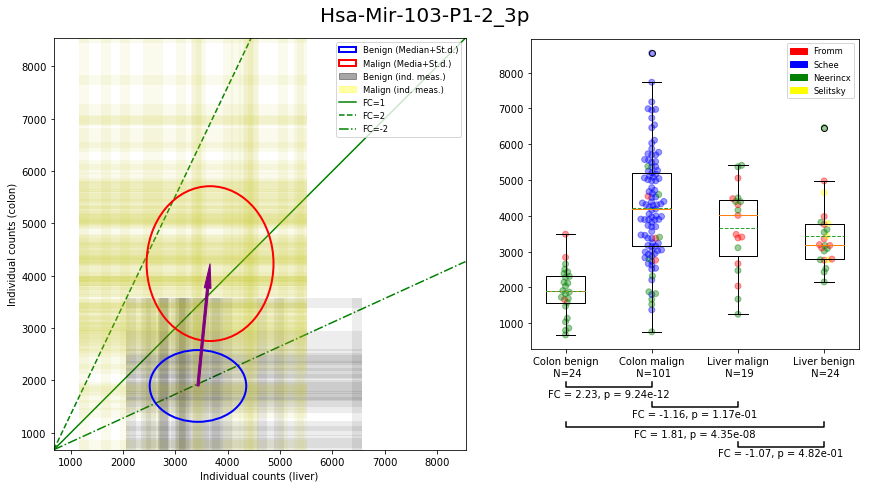

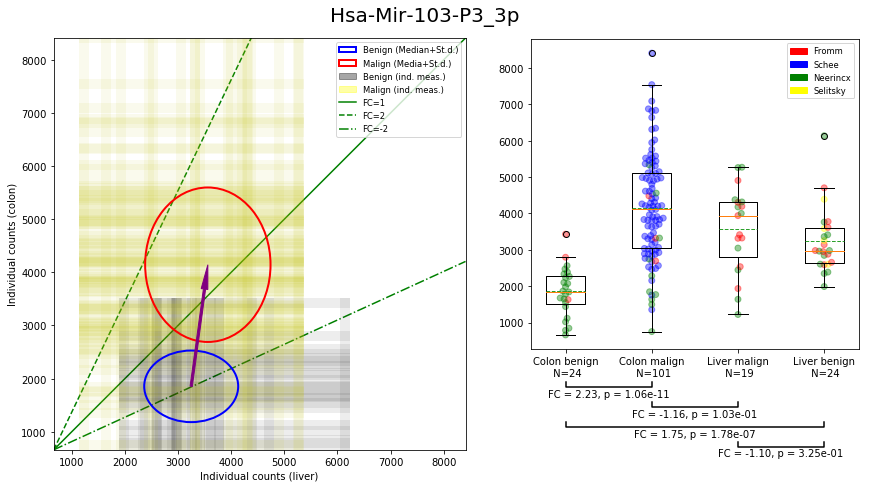

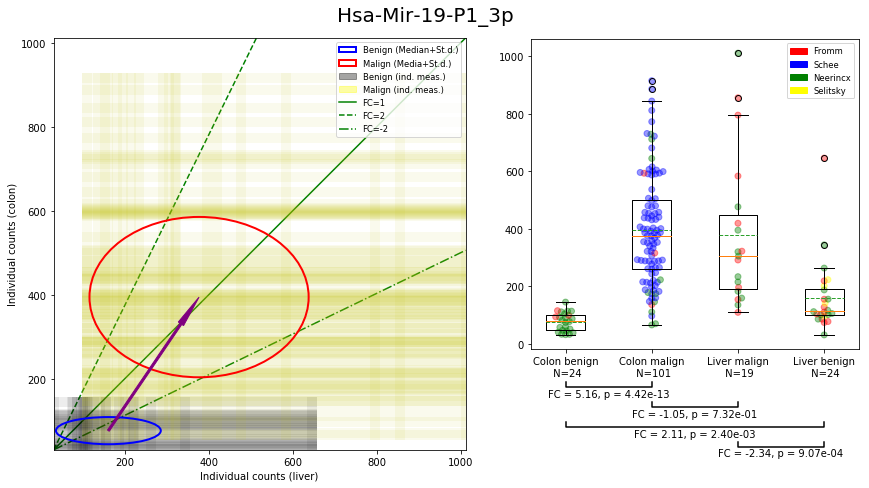

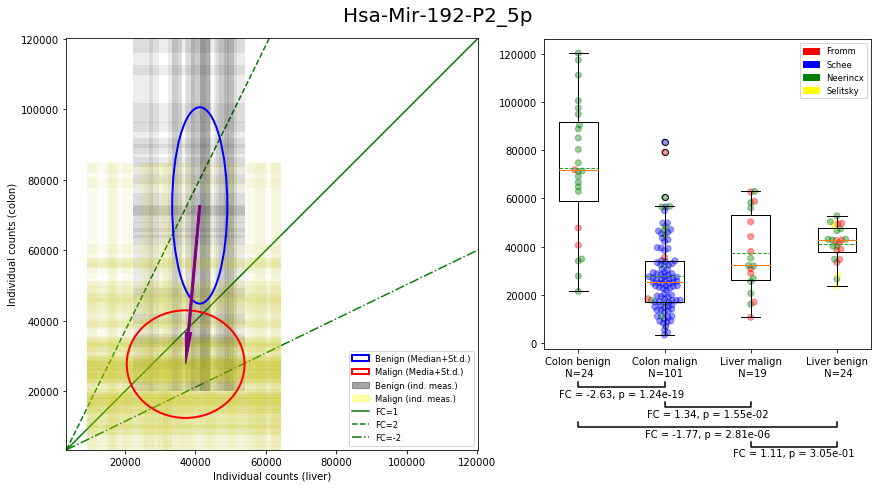

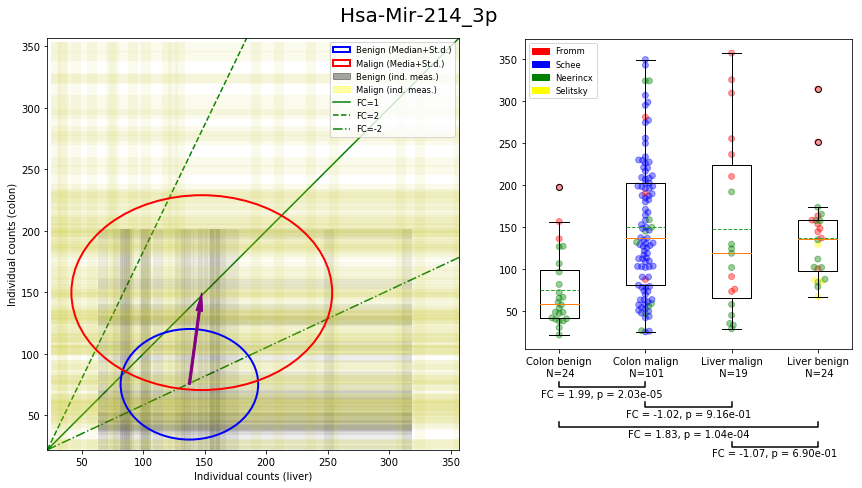

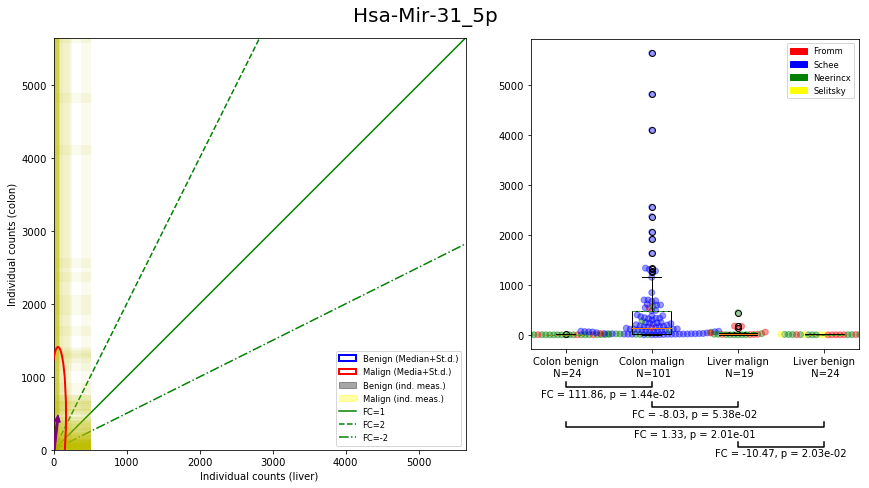

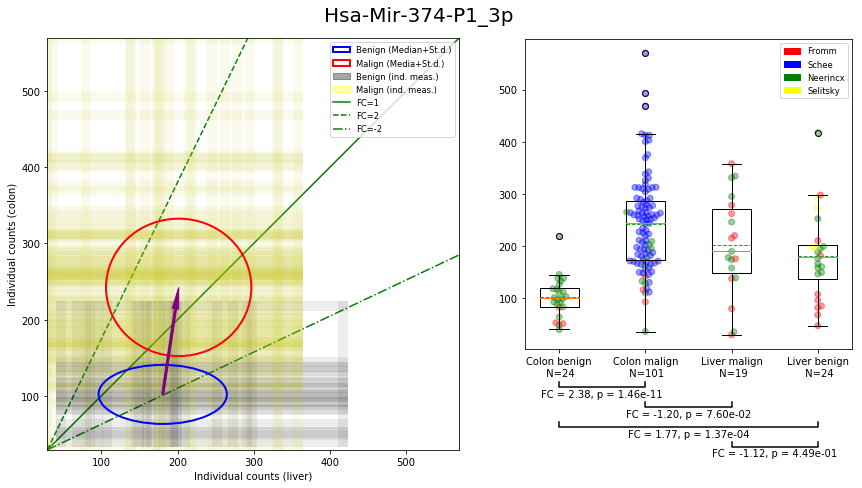

In [7]:
for item in list(mirnalist.query(query1).index):
    combplot(item)

Now we consider the miRNA that are expressed stronger in one specific tissue, regardless of being malign or benign. Additionally, the relative change of liver expression should go in the opposite direction such that liver remnants alone cannot be the reason for the observed changes.

In [8]:
fco=1.5 #cutoff value
query2='total_counts > 400 and tissue_mirna==0 and ((fc_lm_cm > %f and fc_lb_cb > 1 and fc_lb_lm > 1) or (fc_lm_cm < %f and fc_lb_cb < -1 and fc_lb_lm < 1) or (fc_lm_cm > 1 and fc_lb_cb > %f and fc_lb_lm > 1) or (fc_lm_cm < -1 and fc_lb_cb < %f and fc_lb_lm < 1))' % (fco,-fco,fco,-fco)
mirnalist.query(query2)

p_cm_cb       p_cm_lm       p_cb_lb       p_lm_lb  \
Hsa-Let-7-P12_5p      4.278984e-08  9.754251e-05  2.463661e-01  3.992346e-03   
Hsa-Mir-10-P1b_5p     1.686720e-07  1.056620e-03  1.528002e-11  4.396471e-03   
Hsa-Mir-10-P3a_5p     1.952070e-04  1.203257e-04  2.985387e-01  7.750291e-01   
Hsa-Mir-10-P3b-c_5p   2.163696e-02  1.577741e-05  4.070701e-10  4.395448e-07   
Hsa-Mir-101-P1-2_3p   9.622964e-03  8.965294e-01  3.370908e-09  5.898246e-07   
Hsa-Mir-130-P4a_3p    8.640889e-08  4.338700e-02  7.069612e-04  1.805019e-07   
Hsa-Mir-132-P1_3p     4.935832e-04  1.277487e-01  4.443287e-03  1.947944e-04   
Hsa-Mir-133-P1-2_3p   3.328335e-06  2.296974e-02  1.253967e-03  9.973500e-04   
Hsa-Mir-133-P3_3p     3.417998e-06  2.256880e-02  1.284160e-03  1.128420e-03   
Hsa-Mir-148-P1_3p     1.153669e-03  7.680352e-01  7.866799e-16  9.428689e-10   
Hsa-Mir-148-P3_3p     6.326702e-07  2.986384e-02  3.863244e-10  1.251173e-10   
Hsa-Mir-154-P23_3p    5.159606e-03  7.571064e-01  7.350122e-08  6.396568e-02   
Hsa-Mir-155_5p        7.347544e-02  5.217519e-01  1.533595e-03  1.893181e-04   
Hsa-Mir-17-P4_5p      1.118859e-12  1.085859e-04  9.378608e-02  6.146977e-07   
Hsa-Mir-181-P1c_5p    1.160667e-09  7.459491e-01  1.779322e-09  3.364880e-08   
Hsa-Mir-190-P1_5p     1.352768e-07  5.980554e-02  8.658638e-10  5.022357e-08   
Hsa-Mir-193-P1b_3p    2.458750e-05  2.619620e-01  8.538984e-16  3.873775e-09   
Hsa-Mir-196-P1_5p     1.298715e-02  1.548384e-01  2.345040e-10  1.300915e-08   
Hsa-Mir-196-P2_5p     1.172808e-02  1.477113e-01  2.511455e-10  1.353987e-08   
Hsa-Mir-197_3p        1.764366e-01  5.450440e-02  2.621390e-02  4.557850e-01   
Hsa-Mir-203_3p        6.663538e-06  9.536963e-01  2.832958e-11  1.501375e-08   
Hsa-Mir-221-P1_3p     8.328585e-09  1.717636e-01  1.273383e-09  1.007646e-09   
Hsa-Mir-26-P1-2_5p    3.613054e-09  3.664759e-09  2.044199e-01  2.540657e-01   
Hsa-Mir-26-P3_5p      2.600953e-01  4.388321e-01  1.909049e-10  6.501349e-09   
Hsa-Mir-27-P1_3p      2.442735e-01  8.444223e-01  2.787528e-11  2.911006e-07   
Hsa-Mir-27-P2_3p      2.477911e-01  8.437290e-01  8.743815e-12  1.212822e-07   
Hsa-Mir-30-P1a_5p     3.724232e-05  8.297463e-01  2.473499e-15  3.488121e-14   
Hsa-Mir-423_5p        2.814707e-02  6.353657e-05  4.484185e-03  3.715941e-01   
Hsa-Mir-455_5p        9.906337e-07  9.275660e-01  8.123166e-16  5.062153e-10   
Hsa-Mir-574_3p        2.989024e-01  3.256953e-02  1.237381e-03  6.282096e-03   
Hsa-Mir-8-P1a_3p      6.097012e-01  4.507897e-01  2.252928e-13  3.599055e-11   
Hsa-Mir-8-P2a_3p      5.167330e-03  5.436831e-02  5.382520e-15  5.533294e-09   
Hsa-Mir-8-P2b_3p      3.267946e-02  4.182001e-01  7.100881e-15  2.598245e-09   
Hsa-Mir-8-P3a_3p      2.634176e-05  8.103155e-02  2.488830e-13  8.552498e-09   
Hsa-Mir-92-P3_3p      1.243859e-07  8.175276e-02  3.691214e-07  4.146636e-05   

                      fc_cm_cb  fc_lm_cm   fc_lb_cb   fc_lb_lm  N_cb  N_cm  \
Hsa-Let-7-P12_5p      2.771537 -2.005364  -1.167641  -1.613713    24   101   
Hsa-Mir-10-P1b_5p    -2.055630 -2.603610 -25.824510  -4.825943    24   101   
Hsa-Mir-10-P3a_5p    -1.638494  1.843955   1.196116   1.062857    24   101   
Hsa-Mir-10-P3b-c_5p  -1.472144  2.111113   4.664502   3.252749    24   101   
Hsa-Mir-101-P1-2_3p   1.225938  1.010537   3.905932   3.152855    24   101   
Hsa-Mir-130-P4a_3p    1.764204 -1.217227  -1.549175  -2.245275    24   101   
Hsa-Mir-132-P1_3p     1.634114 -1.235482  -1.827610  -2.417251    24   101   
Hsa-Mir-133-P1-2_3p  -3.559779 -2.431852 -21.211396  -2.450556    24   101   
Hsa-Mir-133-P3_3p    -3.567060 -2.448525 -21.325184  -2.441933    24   101   
Hsa-Mir-148-P1_3p     1.627490  1.042447   5.175744   3.050705    24   101   
Hsa-Mir-148-P3_3p    -1.626844  1.287631   2.153609   2.720999    24   101   
Hsa-Mir-154-P23_3p    1.480628  1.043737   2.036196   1.317597    24   101   
Hsa-Mir-155_5p        1.348580 -1.115232  -2.347524  -2.838667    24   101   
Hsa-Mir-17-P4_5p      3.427334 -1.699738  -1.255617  -

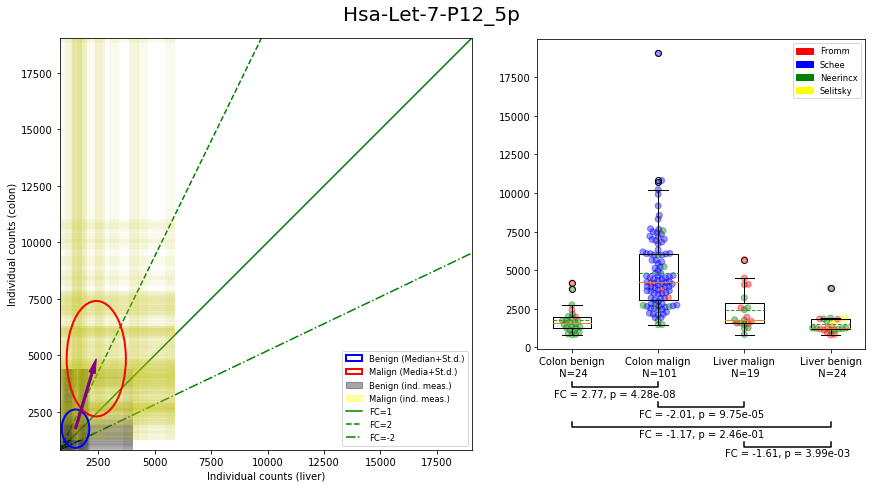

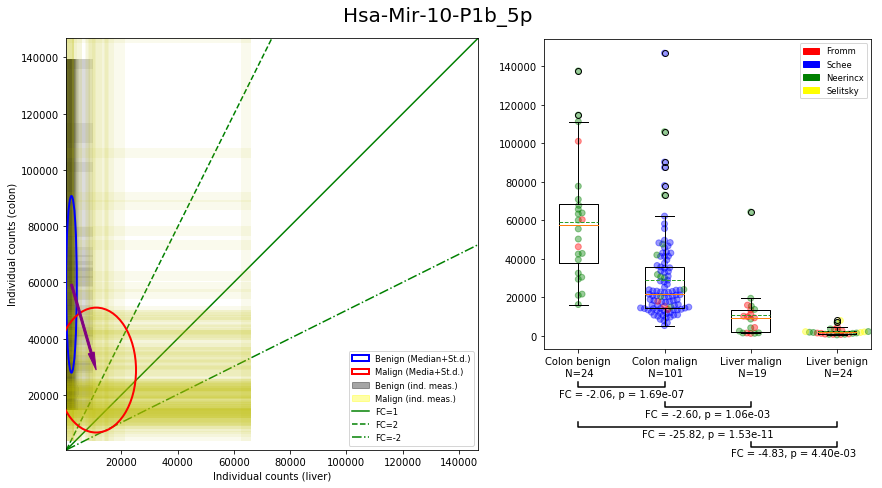

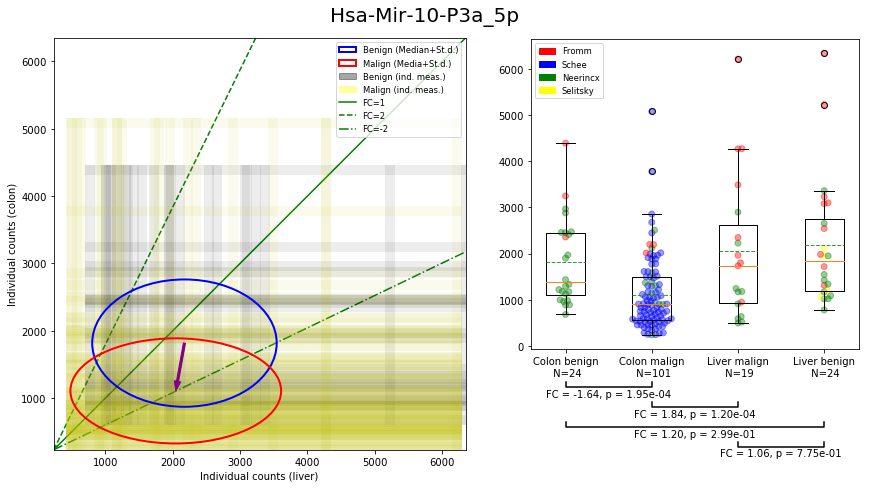

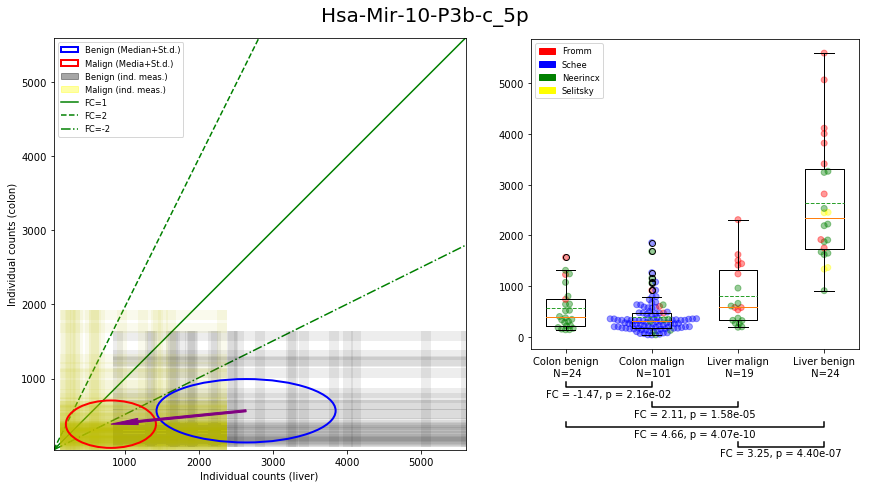

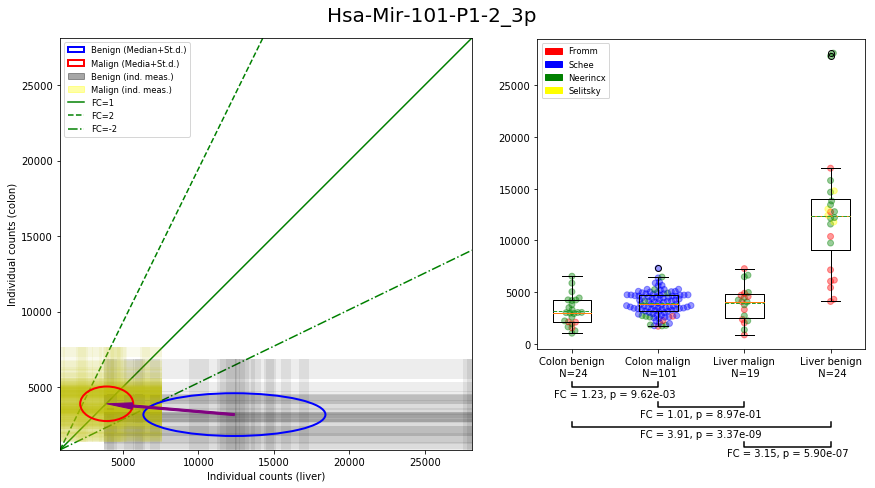

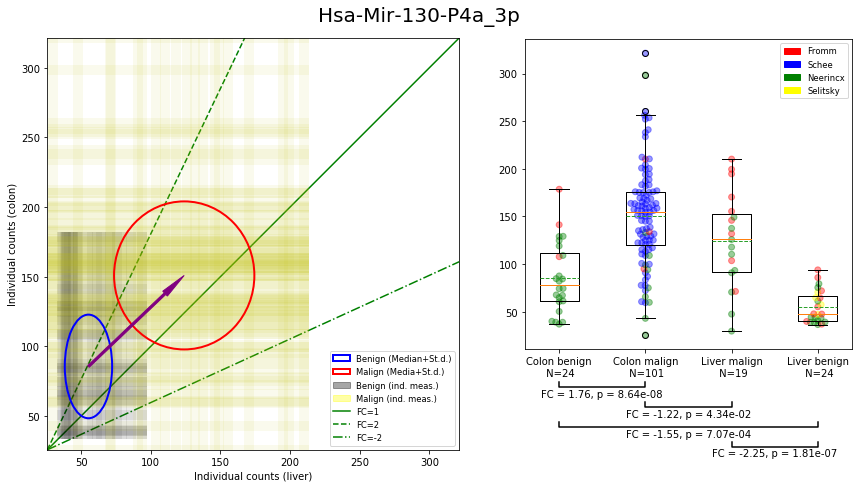

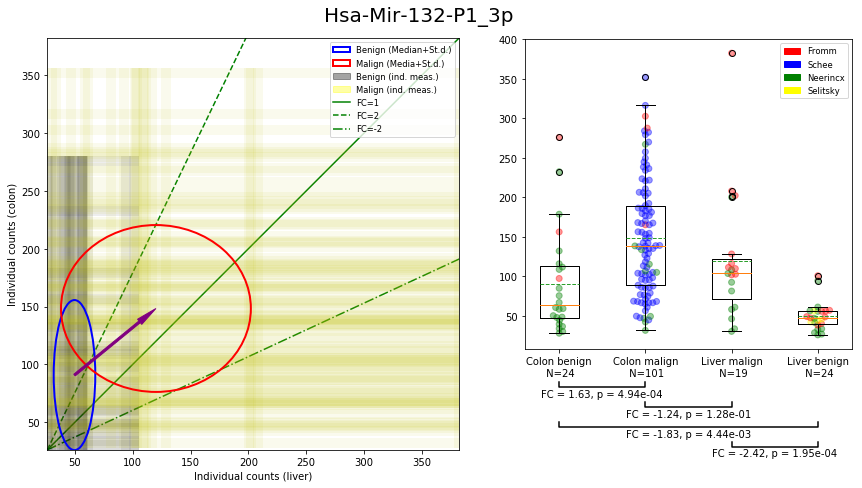

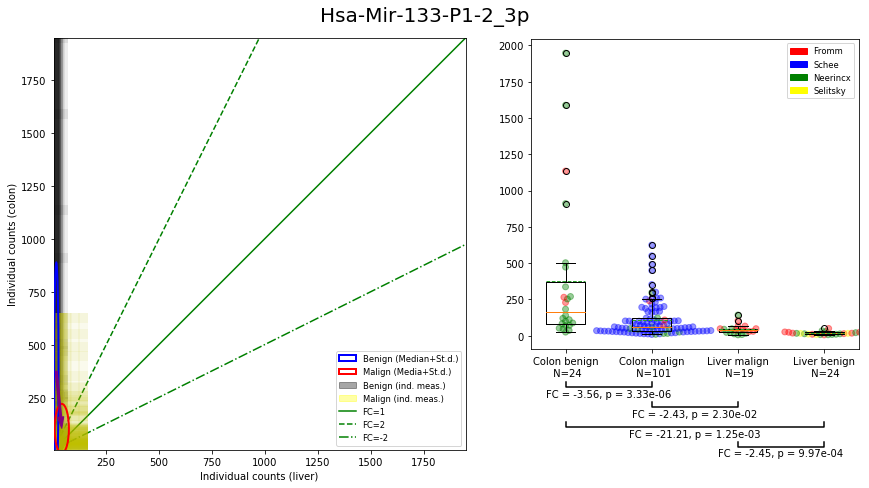

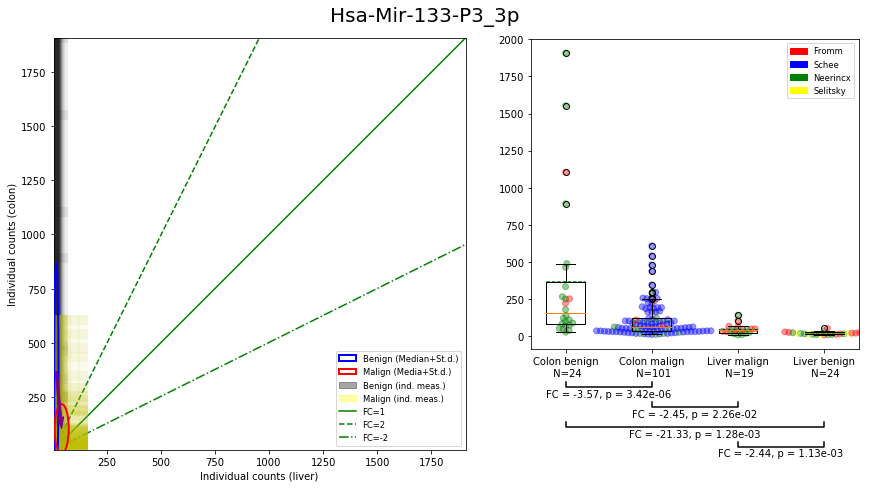

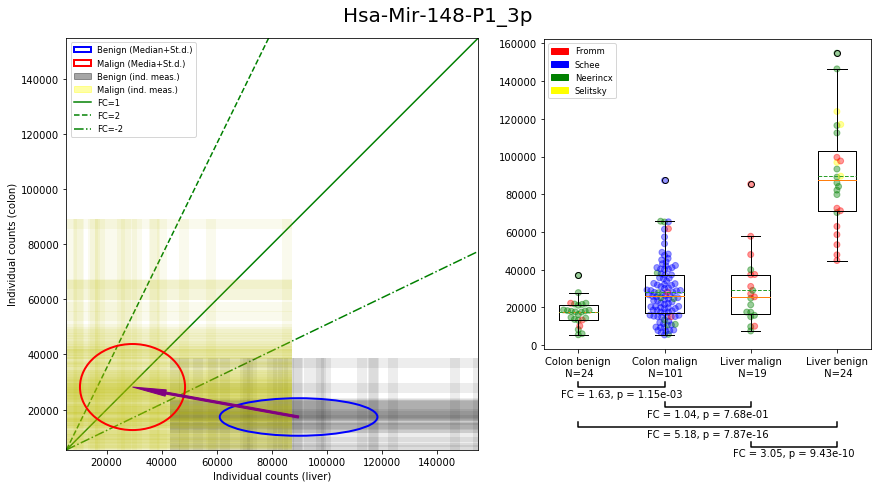

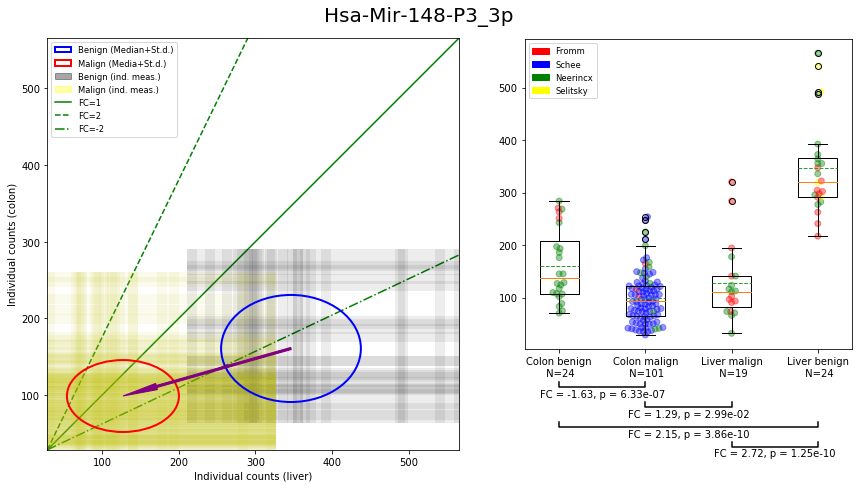

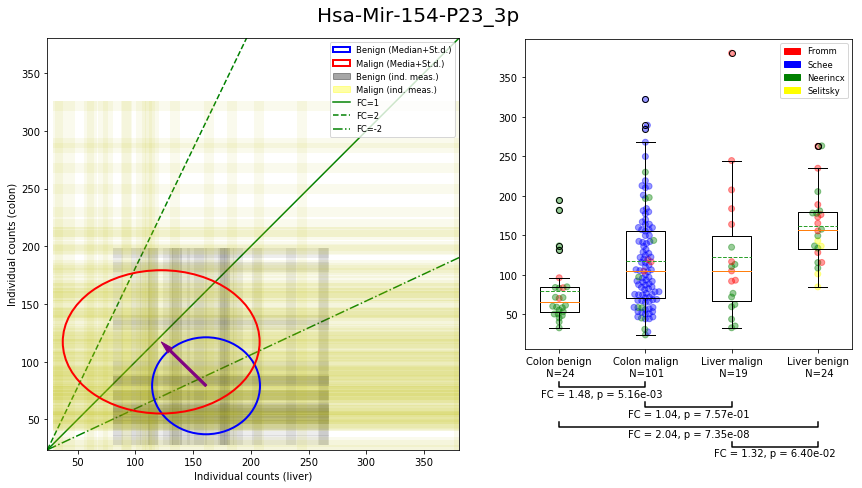

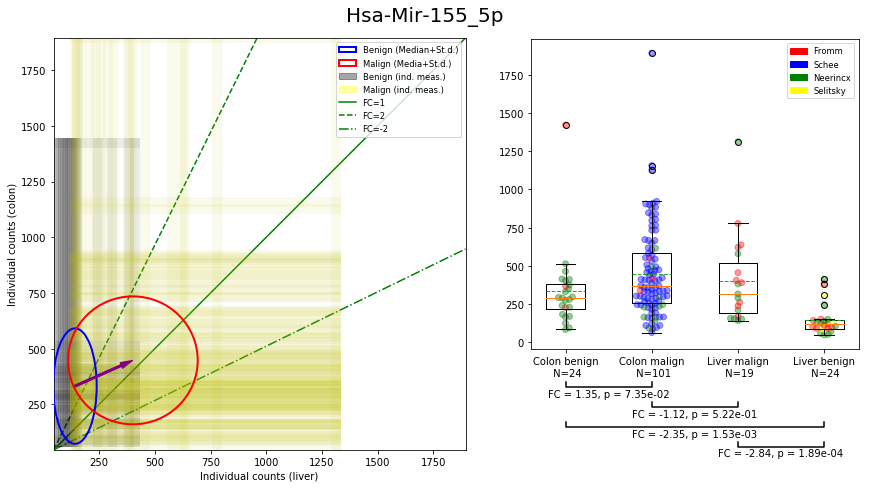

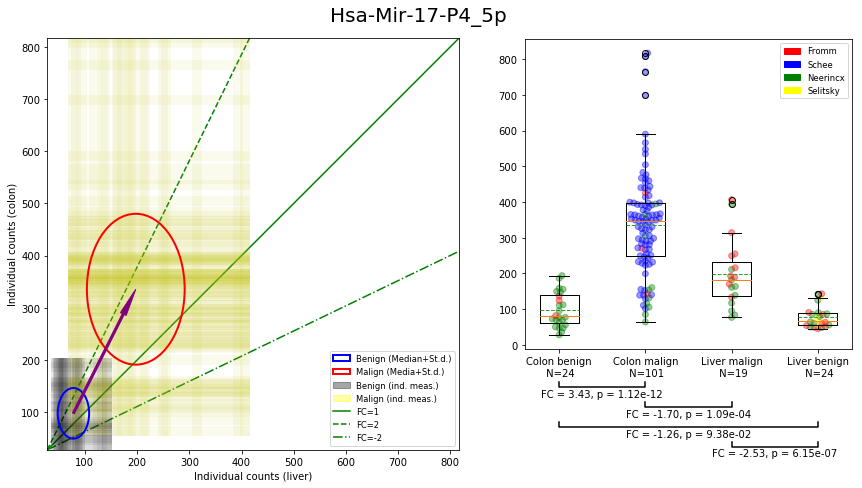

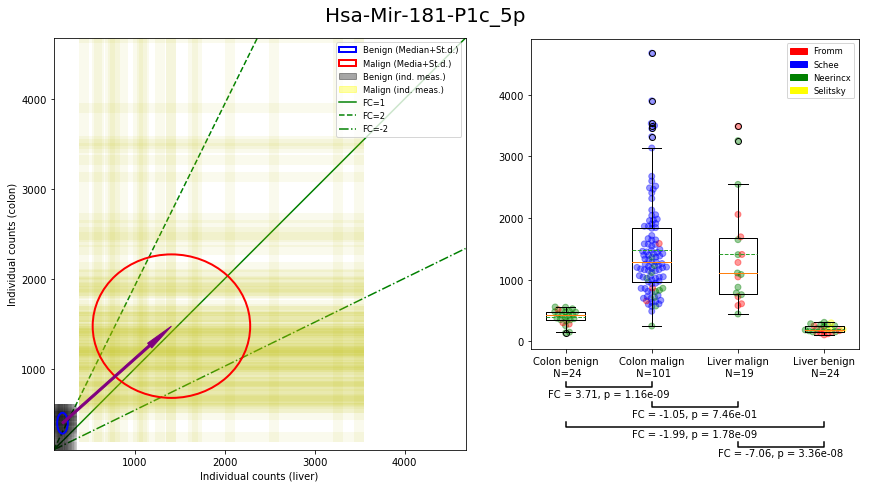

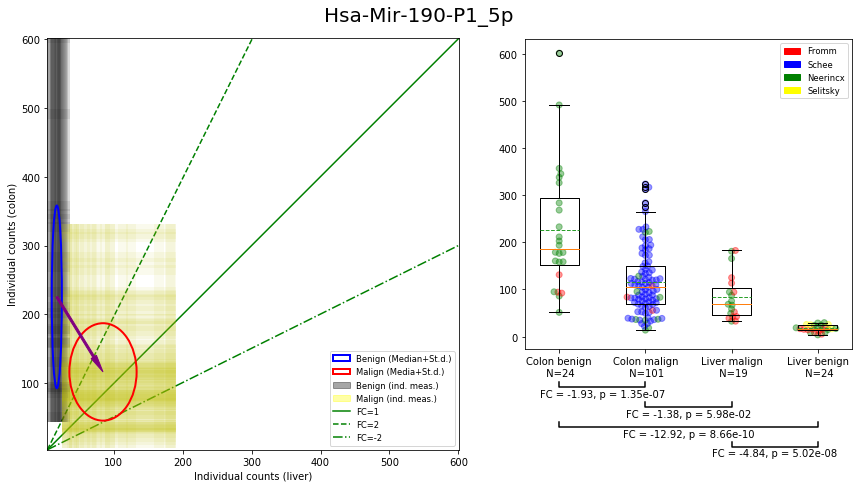

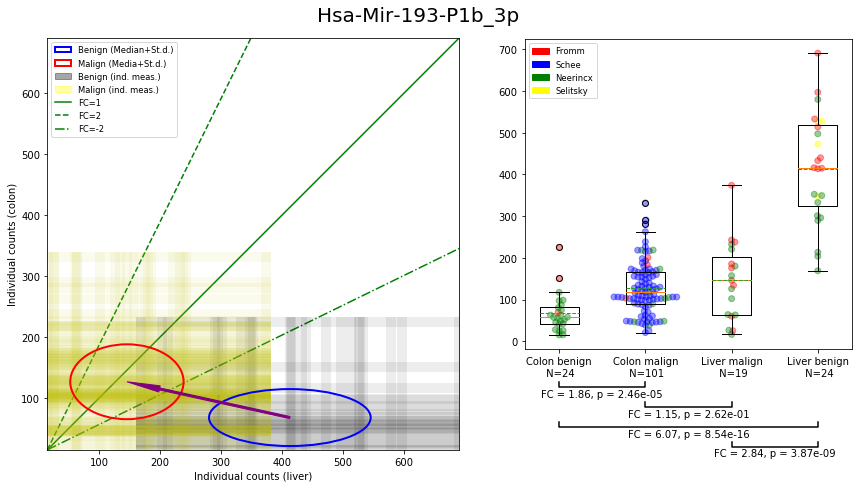

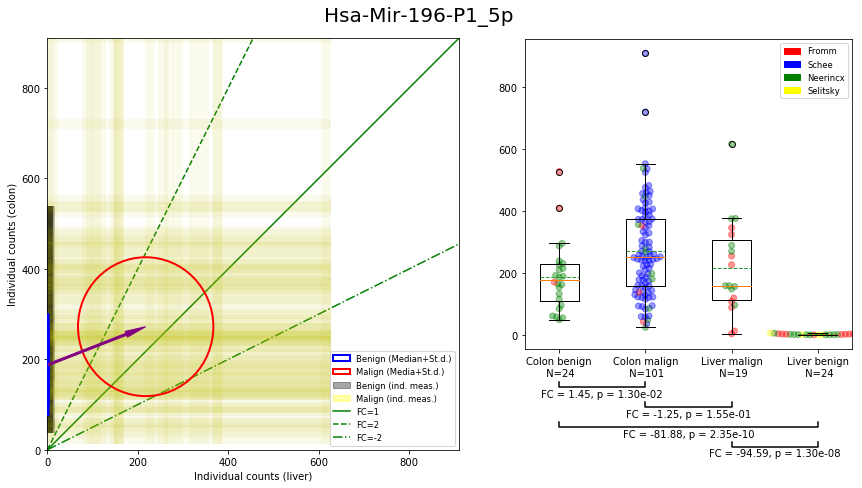

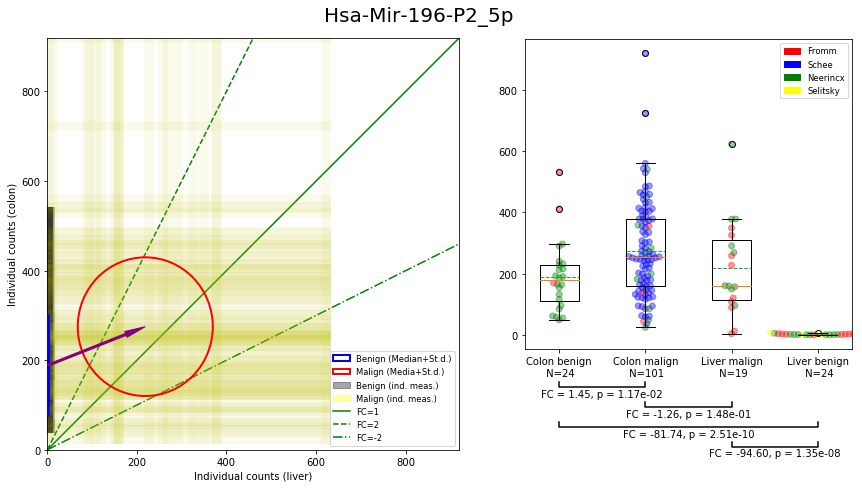

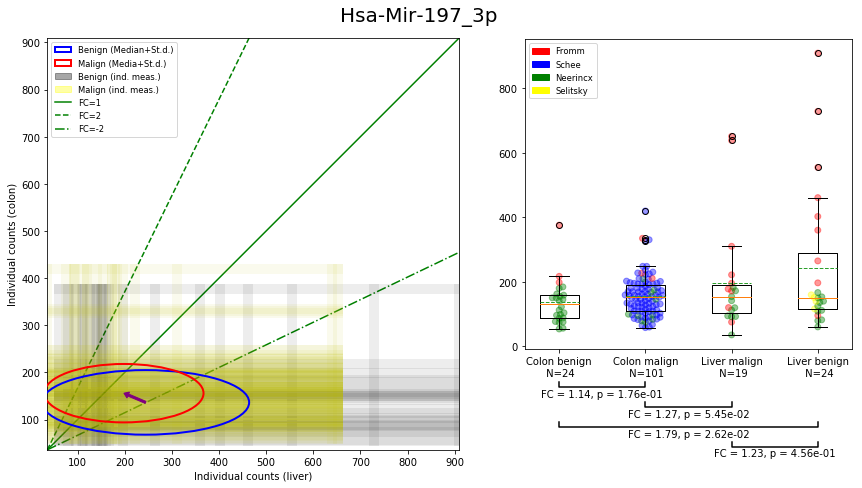

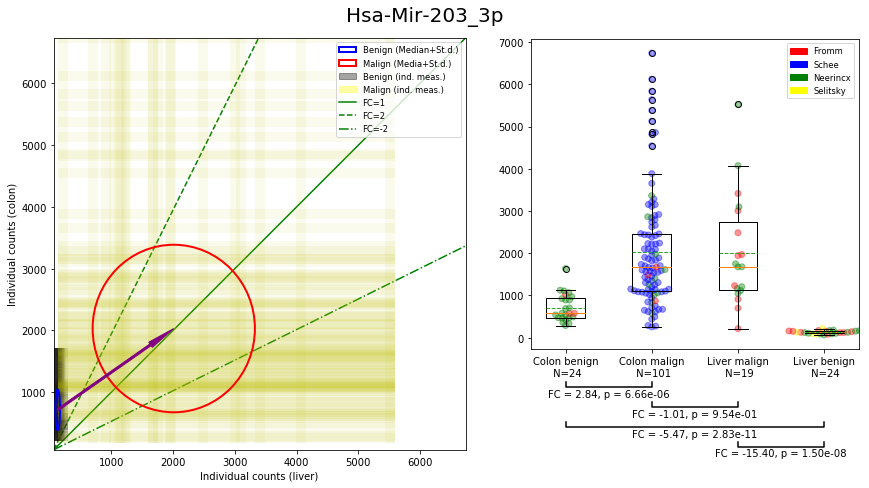

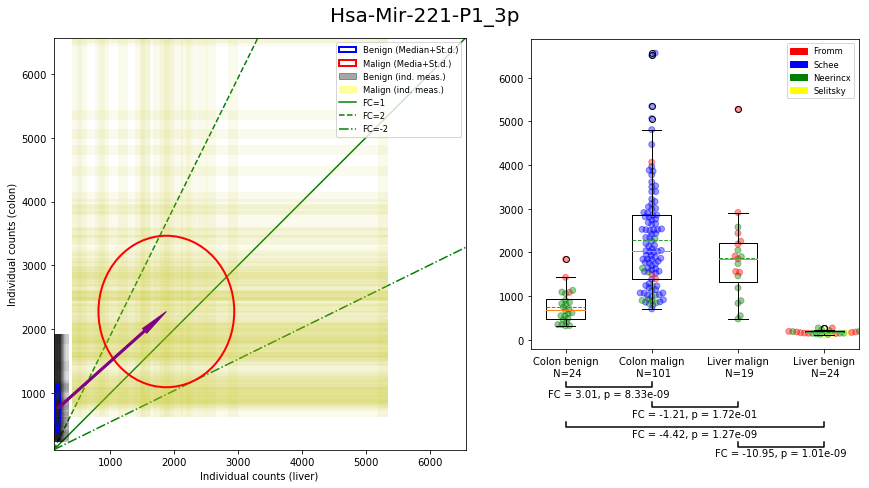

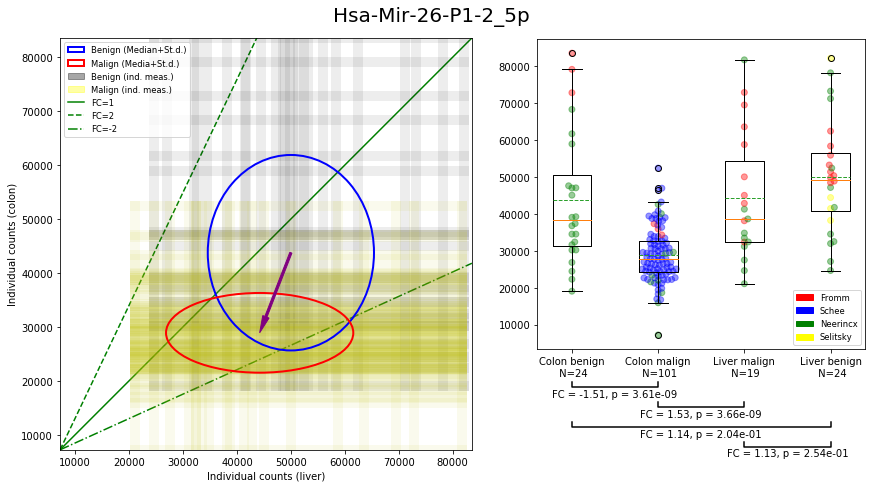

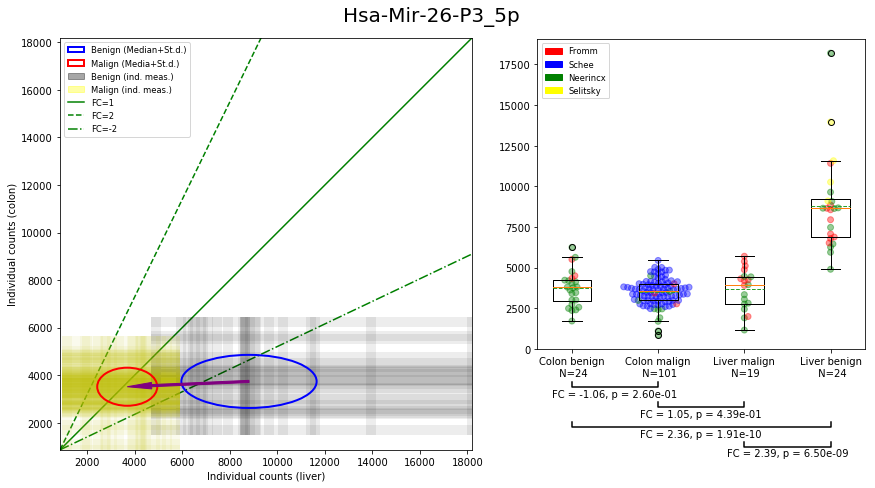

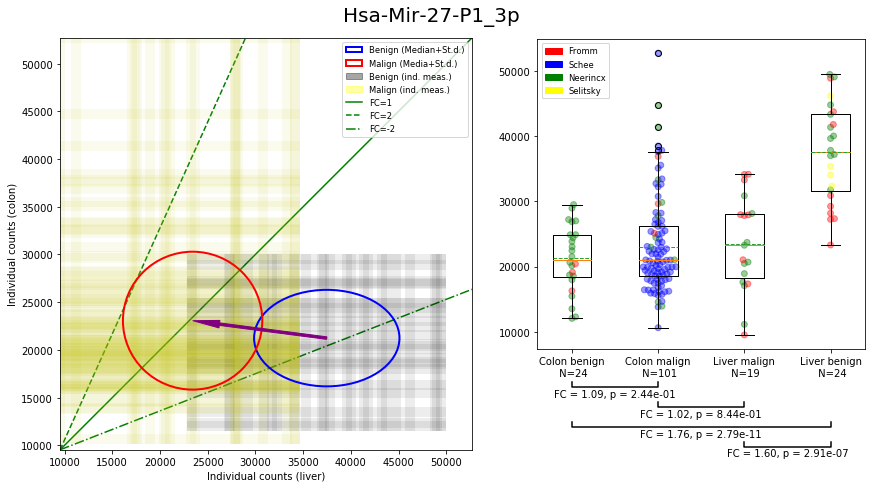

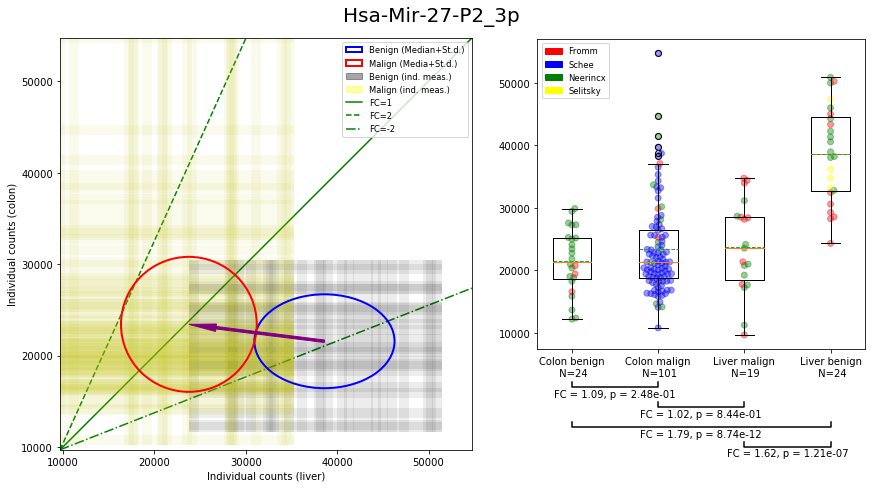

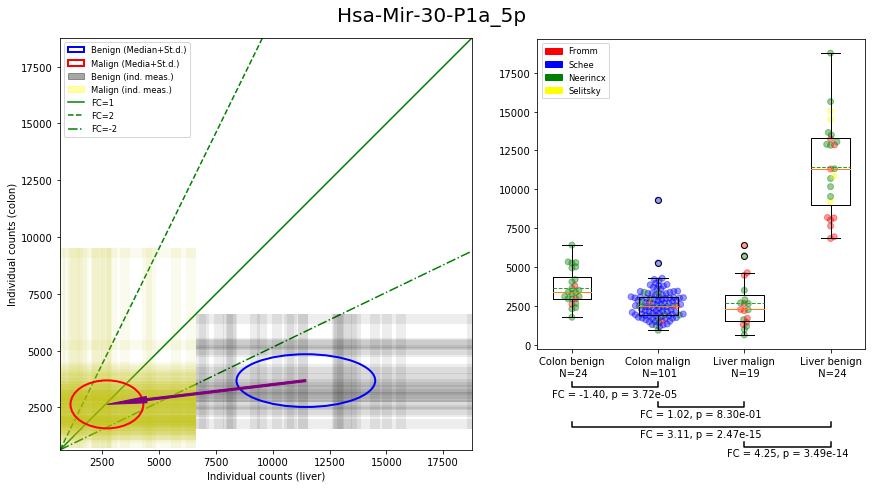

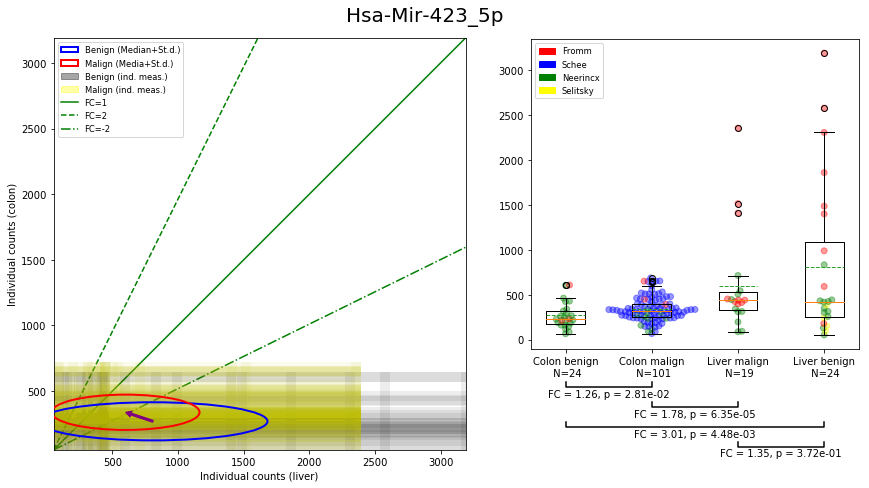

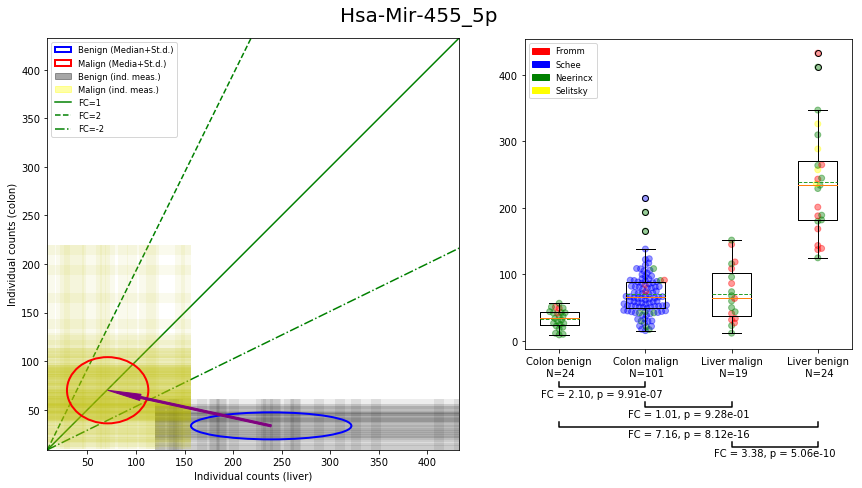

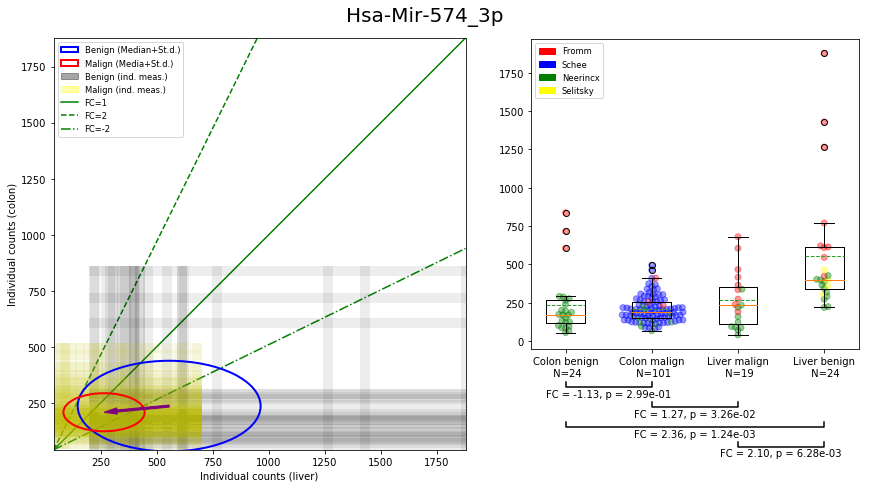

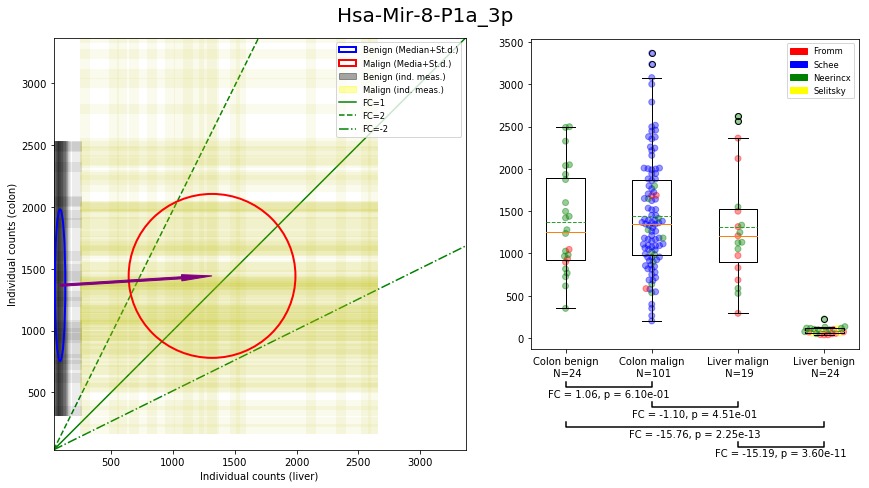

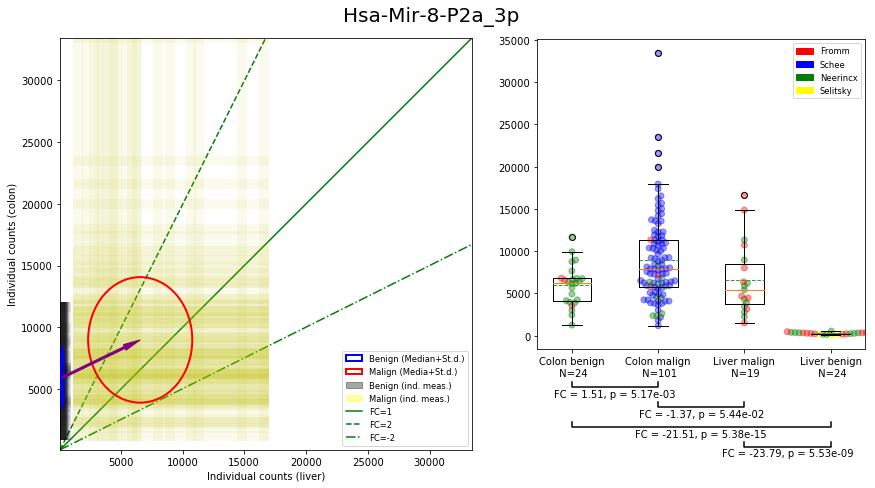

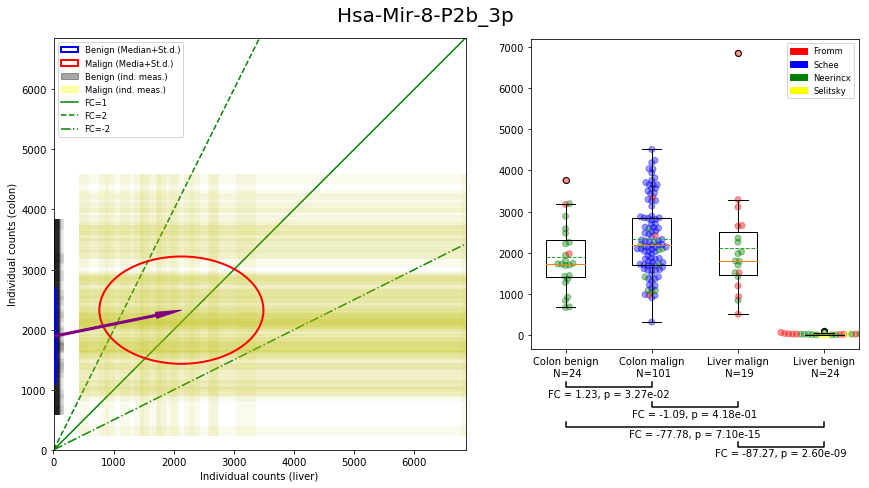

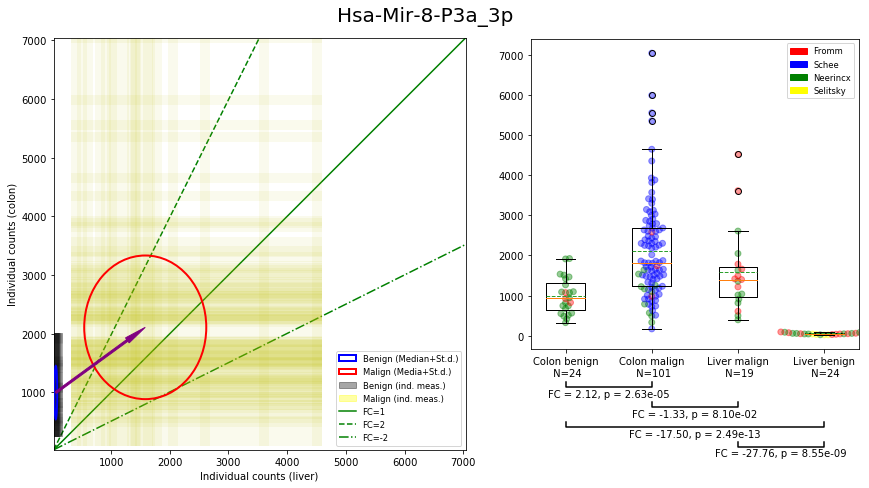

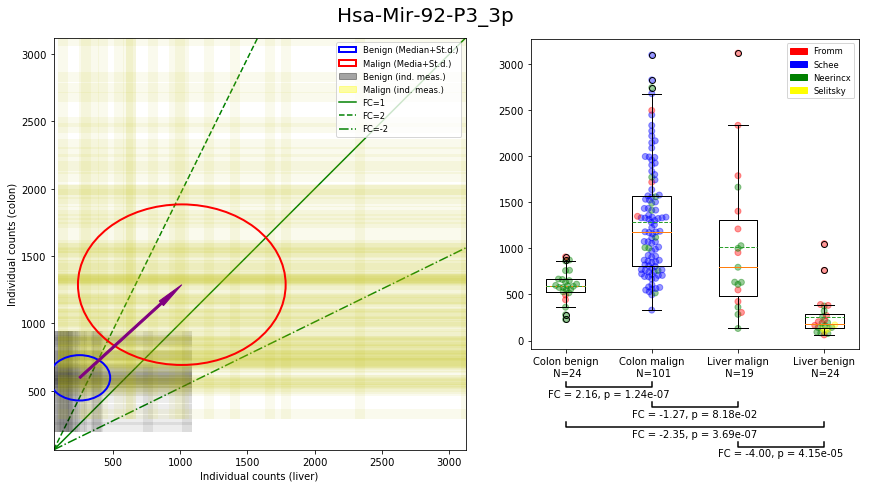

In [9]:
for item in list(mirnalist.query(query2).index):
    combplot(item)